# The Habitual DDPG Network

Habitual network

Assuming generative model is perfect, then action selected would always be the action that maximises chance of observing prior preferences. Hence habitual network can be trained to output maximally rewarding actions, as these actions are the free energy minimising actions.

Also has a nice interpretation as long as the generative models keep training. Eventually the generative model is less sure about old things. Why people eventually revisit old states they were previously certain about.

As far as an agent knows, if observations are confirming perfectly to expectations then it has a perfect world model. So why would it change it? It’s only when an uncertain observation comes in that the agent needs to reconsider whether or not it has the best model of the world.


I think this network should be performing policy gradient method but instead of minimising the discounted reward sequence it should minimise the discounted external EFE/FEEF component sequence. That way in the end the end the fast and slow thinking methods should be converging as the world model continues to improve


What is this network trying to learn?
- This network is trying to learn the state action mapping that maximises the probability of being in the preferred states
- It is also trying to learn to output actions that minimise the extrinsic part of the EFE/FEEF


What does this network take as input?
- Current state
- Maybe sequence of previous states and actions

What should this network output?
- The action that leads to the next state that maximally achieves the prior preferences

How should this network learn?
- It should learn by outputting


Okay so new idea! DDPG seems pretty good so far. How about we have the Q function take latent states as input and use the VAEs good latent features as input. Then we'll have
- Q(o, a)
- p(s|o) and p(o|s)
- p(s'|s, a)
- V(o) or U(o)



In [1]:
from util import random_observation_sequence, transform_observations, test_policy
import matplotlib.pyplot as plt
import gym

from ddpg import *

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

In [3]:
env = gym.make("MountainCarContinuous-v0")

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  2
Size of Action Space ->  1
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


In [4]:
actor_model = get_actor(2, 1)
critic_model = get_critic(2, 1)

target_actor = get_actor(2, 1)
target_critic = get_critic(2, 1)

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.0001
actor_lr = 0.00005

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 140
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

# buffer = Buffer(50000, 64, 0.99, 2, 1, critic_optimizer, actor_optimizer)

ddpg = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau, observation_dim=2,
                 action_dim=1, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)

In [9]:
t_max = 1000
num_episodes = 140

min_reward_cutoff = -1000
min_reward_set = -0.5

reward_increase = 0

# observation_max = np.array([0.6, 0.07])
# observation_min = np.array([-1.2, -0.07])

for i in range(num_episodes):

    all_observations = []
    actions = []
    rewards = []

    total_reward = 0

    o, a, r = random_observation_sequence(env, t_max, epsilon=0.2)
    # o = transform_observations(o, observation_max, observation_min, [0, 0, 0])
    # o = transform_observations(o, observation_max, observation_min, [0.05, 0.05])
    # print(o)
    # print(o)
    for i in range(len(a)):

        prev_state = o[i]
        state = o[i+1]
        action = a[i]
        reward = r[i] + reward_increase


        total_reward += reward

        # ddpg.buffer.record((prev_state, action, reward, state))
        # # episodic_reward += reward
        #
        # ddpg.buffer.learn()

        ddpg.record((prev_state, action, reward, state))
        # episodic_reward += reward

        ddpg.train([], [], [], [])

    print(total_reward)

    acts = ddpg.actor_model((np.random.random(size=(10, 2))*2 - 1))
    print(np.max(acts), np.min(acts))


84.44388641886108
0.09941851 0.029549638
-38.812534757239604
0.890537 0.13881044
83.88063905266861
0.9941826 0.61432123
-31.29173017468946
0.9998344 0.24212939
91.7916874990733
0.9997858 0.20836897
81.93958637911733
1.0 0.23748273
-32.72215476624443
0.99999976 0.18168089
86.69541979653674
1.0 0.18843022
83.05194005663063
1.0 0.24568611
-32.93906421792623
1.0 0.2548205
88.19440711095473
1.0 0.27552977
82.16085391832864
1.0 0.27273014
85.3222192922964
0.99999976 0.3068994
83.54091891832152
1.0 0.3388399
75.39873130901326
1.0 0.44147632
-28.538820374664294
0.99999976 0.53005147
85.9702368891426
1.0 0.53344774
-31.41084784555202
1.0 0.5547698
-31.735743823628273
1.0 0.5744055
73.52242460851687
0.99999976 0.5961823
83.41729897667241
1.0 0.5679074
77.03998056966181
0.99999976 0.6229303
84.88782433063233
1.0 0.9999685
68.2948947492826
1.0 0.9978023
72.4311911715754
1.0 0.806017
93.01867253129174
1.0 0.99999976
82.23043234612781
1.0 0.73086965
92.8409868790563
1.0 0.637782
-31.7831750049092
1.

In [14]:
ddpg.critic_model([(np.random.random(size=(10, 2))*2 - 1), (np.random.random(size=(10, 1))*2 - 1)])

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[31579944. ],
       [20385646. ],
       [ 9055390. ],
       [ 6340939.5],
       [69154368. ],
       [46130672. ],
       [15956278. ],
       [40372884. ],
       [19186736. ],
       [18231190. ]], dtype=float32)>

In [15]:
ddpg.actor_model((np.random.random(size=(10, 2))*2 - 1))

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 0.99999976],
       [ 0.99999976],
       [ 0.99999976],
       [ 0.99999976],
       [ 0.99999976],
       [ 0.99999976],
       [ 0.99999976],
       [-0.9999993 ],
       [ 1.        ],
       [ 1.        ]], dtype=float32)>

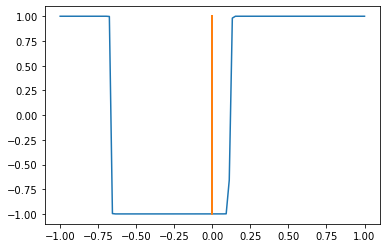

In [16]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T
actions_pred = ddpg.actor_model(obs_pos)

actions_pred


plt.plot(obs_pos, actions_pred)

tf.Tensor(
[[-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999976]
 [-0.99999964]
 [-0.99999946]
 [-0.9999992 ]
 [-0.9999989 ]
 [-0.9999985 ]
 [-0.9999978 ]
 [-0.99999684]
 [-0.9999955 ]
 [-0.9999936 ]
 [-0.9999912 ]
 [-0.9999875 ]
 [-0.9999827 ]
 [-0.9999761 ]
 [-0.99996674]
 [-0.9999546 ]
 [-0.9999388 ]
 [-0.99991745]
 [-0.999889  ]
 [-0.9998549 ]
 [-0.99980015]
 [-0.9997189 ]
 [-0.99966556]
 [ 0.9998297 ]
 [ 0.99999976]
 [ 0.99999976]
 [ 0.99999976]
 [ 0.99999976]
 [ 0.99999976]
 [ 0.99999976]
 [ 0.99999976]
 [ 0.99999976]
 [ 0.99999976]
 [ 0.99999976]
 [ 0.99999976]
 [ 0.99999976]
 [ 0.99999976]
 [ 0.99999976]
 [ 0.99999976]

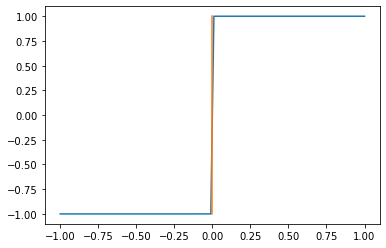

In [17]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T
actions_pred = ddpg.actor_model(vel_pos)
print(actions_pred)

plt.plot(obs_pos, actions_pred)

## Can it solve the environment?

In [18]:
test_policy(env, ddpg.actor_model, None, None, None, 5, 1, show_env=True)

,reward,timesteps,num_actions
0,93.559703,65,65
1,93.320116,67,67
2,93.520162,65,65
3,93.333026,67,67
4,93.323683,67,67


In [19]:
test_policy(env, ddpg.actor_model, None, None, None, 5, 1)

,reward,timesteps,num_actions
0,93.528787,65,65
1,93.506153,65,65
2,93.402073,66,66
3,93.402295,66,66
4,93.474632,66,66


In [10]:
n = 50
both = [[i/n, j/n] for i in range(-1*n, n) for j in range(-1*n, n)]
both = np.array(both)
both

both_acts = act_net(both)

both_acts

NameError: name 'act_net' is not defined

In [ ]:
n = 50
coords = [[i/n, j/n] for i in range(-1*n, n) for j in range(-1*n, n)]
coords = np.array(coords)
coords


In [ ]:
x = np.arange(-5, 5.1, 0.5)
y = np.arange(-5, 5.1, 0.5)
X,Y = np.meshgrid(x,y)

X